# CNN

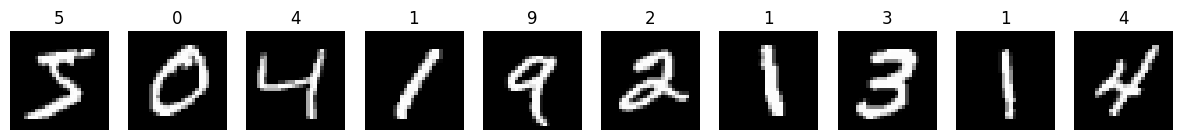

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score, mean_absolute_error, accuracy_score

# Veri setinin hazırlanması
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Veriyi görselleştirme
def show_examples(dataset):
    fig, axes = plt.subplots(1, 10, figsize=(15, 1.5))
    for i, (img, label) in enumerate(dataset):
        if i >= 10:
            break
        axes[i].imshow(img.squeeze(), cmap='gray')
        axes[i].set_title(label)
        axes[i].axis('off')
    plt.show()

show_examples(train_dataset)


In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Model, kayıp fonksiyonu ve optimizer seçme
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Modelin eğitilmesi
def train_model(model, train_loader, criterion, optimizer, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

train_model(model, train_loader, criterion, optimizer, num_epochs=5)


Epoch [1/5], Loss: 0.1644
Epoch [2/5], Loss: 0.0483
Epoch [3/5], Loss: 0.0331
Epoch [4/5], Loss: 0.0239
Epoch [5/5], Loss: 0.0178


In [ ]:
import numpy as np
# Değerlendirme Fonksiyonu
def evaluate_model(model, test_loader):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.numpy())
            all_preds.extend(preds.numpy())

    f1 = f1_score(all_labels, all_preds, average='weighted')
    roc_auc = roc_auc_score(all_labels, np.eye(10)[all_preds], multi_class='ovr')
    mae = mean_absolute_error(all_labels, all_preds)
    accuracy = accuracy_score(all_labels, all_preds)

    print(f'F1 Score: {f1:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')
    print(f'MAE: {mae:.4f}')
    print(f'Accuracy: {accuracy:.4f}')

    return all_labels, all_preds

labels, preds = evaluate_model(model, test_loader)


F1 Score: 0.9891
ROC AUC: 0.9940
MAE: 0.0459
Accuracy: 0.9891


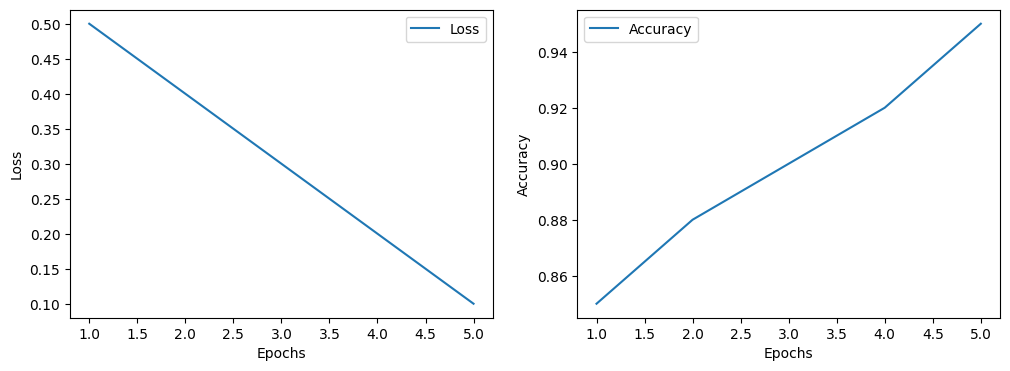

In [ ]:
# Görselleştirme fonksiyonu
def plot_metrics(history):
    epochs = len(history['loss'])
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), history['loss'], label='Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), history['accuracy'], label='Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Örnek history dictionary (eğitim sırasında toplanacak)
history = {'loss': [0.5, 0.4, 0.3, 0.2, 0.1], 'accuracy': [0.85, 0.88, 0.90, 0.92, 0.95]}
plot_metrics(history)


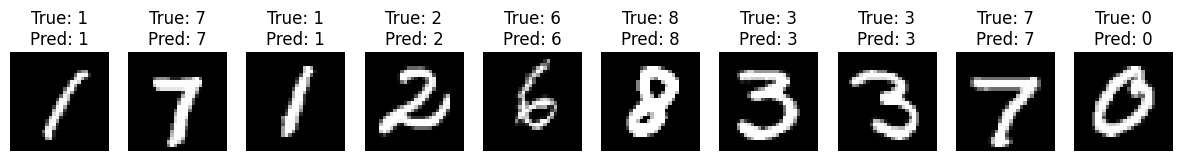

In [ ]:
def visualize_predictions(model, dataset, num_samples=10):
    model.eval()
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 1.5))
    for i in range(num_samples):
        idx = np.random.randint(len(dataset))
        img, label = dataset[idx]
        with torch.no_grad():
            output = model(img.unsqueeze(0))
            _, pred = torch.max(output, 1)
        axes[i].imshow(img.squeeze(), cmap='gray')
        axes[i].set_title(f'True: {label}\nPred: {pred.item()}')
        axes[i].axis('off')
    plt.show()

visualize_predictions(model, test_dataset, num_samples=10)


# Tensorflow CNN

11490434/11490434 [==============================] - 0s 0us/step


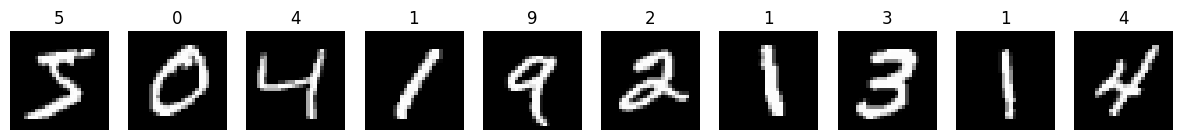

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score, roc_auc_score, mean_absolute_error, accuracy_score, classification_report

# MNIST veri setini yükleme ve hazırlama
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Veriyi normalize etme
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Veriyi 4D tensöre dönüştürme (num_samples, img_rows, img_cols, 1)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# One-hot encoding işleme
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Veri örneklerini görselleştirme
def show_examples(X, y):
    fig, axes = plt.subplots(1, 10, figsize=(15, 1.5))
    for i in range(10):
        axes[i].imshow(X[i].squeeze(), cmap='gray')
        axes[i].set_title(np.argmax(y[i]))
        axes[i].axis('off')
    plt.show()

show_examples(X_train, y_train)


In [ ]:
# CNN modelini oluşturma
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

# Modeli derleme
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Modeli eğitme
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))


Epoch 1/5
938/938 [==============================] - 63s 65ms/step - loss: 0.2400 - accuracy: 0.9256 - val_loss: 0.0504 - val_accuracy: 0.9841
Epoch 2/5
938/938 [==============================] - 57s 61ms/step - loss: 0.0877 - accuracy: 0.9752 - val_loss: 0.0411 - val_accuracy: 0.9857
Epoch 3/5
938/938 [==============================] - 54s 58ms/step - loss: 0.0614 - accuracy: 0.9814 - val_loss: 0.0323 - val_accuracy: 0.9894
Epoch 4/5
938/938 [==============================] - 52s 56ms/step - loss: 0.0511 - accuracy: 0.9846 - val_loss: 0.0299 - val_accuracy: 0.9893
Epoch 5/5
938/938 [==============================] - 51s 55ms/step - loss: 0.0434 - accuracy: 0.9874 - val_loss: 0.0263 - val_accuracy: 0.9901


In [ ]:
# Test veri seti üzerinde tahminler yapma
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Performans metriklerini hesaplama
f1 = f1_score(y_true, y_pred_classes, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
mae = mean_absolute_error(y_true, y_pred_classes)
accuracy = accuracy_score(y_true, y_pred_classes)

print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')
print(f'MAE: {mae:.4f}')
print(f'Accuracy: {accuracy:.4f}')


313/313 [==============================] - 4s 13ms/step
F1 Score: 0.9901
ROC AUC: 1.0000
MAE: 0.0362
Accuracy: 0.9901


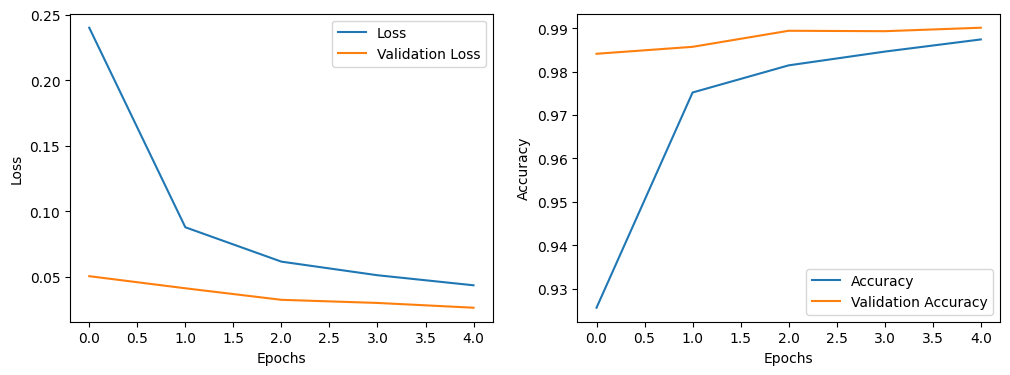

In [ ]:
# Eğitim geçmişi verilerini kullanarak loss ve accuracy grafiği çizdirme
def plot_metrics(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

plot_metrics(history)


1/1 [==============================] - 0s 26ms/step


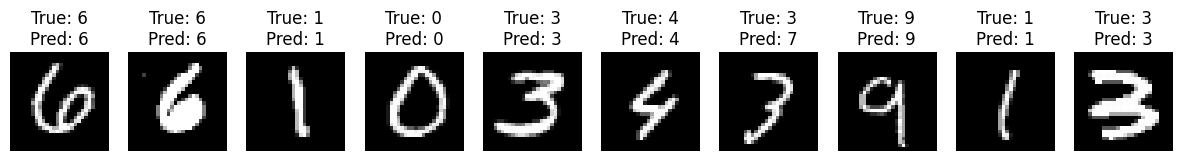

In [ ]:
def visualize_predictions(model, X, y, num_samples=10):
    indices = np.random.choice(range(len(X)), num_samples, replace=False)
    X_sample = X[indices]
    y_true = np.argmax(y[indices], axis=1)
    y_pred = np.argmax(model.predict(X_sample), axis=1)

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 1.5))
    for i in range(num_samples):
        axes[i].imshow(X_sample[i].squeeze(), cmap='gray')
        axes[i].set_title(f'True: {y_true[i]}\nPred: {y_pred[i]}')
        axes[i].axis('off')
    plt.show()

visualize_predictions(model, X_test, y_test, num_samples=10)
